In [1]:
import numpy as np
import pandas as pd
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import OrderedDict
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

C:\Users\ladwi\anaconda3\envs\deeplearning\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')
    
print(device)

cuda:0


In [3]:
print(device)

cuda:0


In [4]:
# the deep neural network
class MLP(torch.nn.Module):
    def __init__(self, layers, activation="relu", init="xavier"):
        super(MLP, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        if activation == "relu":
            self.activation = torch.nn.ReLU()
        elif activation == "tanh":
            self.activation = torch.nn.Tanh()
        elif activation == "gelu":
            self.activation = torch.nn.GELU()
        else:
            raise ValueError("Unspecified activation type")
        
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)

        if init=="xavier":
            self.xavier_init_weights()
        elif init=="kaiming":
            self.kaiming_init_weights()
    
    def xavier_init_weights(self):
        with torch.no_grad():
            print("Initializing Network with Xavier Initialization..")
            for m in self.layers.modules():
                if hasattr(m, 'weight'):
                    nn.init.xavier_uniform_(m.weight)
                    m.bias.data.fill_(0.0)

    def kaiming_init_weights(self):
        with torch.no_grad():
            print("Initializing Network with Kaiming Initialization..")
            for m in self.layers.modules():
                if hasattr(m, 'weight'):
                    nn.init.kaiming_uniform_(m.weight)
                    m.bias.data.fill_(0.0)
                        
    def forward(self, x):
        out = self.layers(x)
        return out
    
class DataGenerator(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        
    def __getitem__(self, index):
        return self.X[index], self.Y[index]
    
    def __len__(self):
        return len(self.X)

In [5]:
data_df = pd.read_csv("all_data_lake_modeling_in_time_wHeat.csv")
data_df = data_df.drop(columns=['time'])
data_df

,depth,AirTemp_degC,Longwave_Wm-2,Latent_Wm-2,Sensible_Wm-2,Shortwave_Wm-2,lightExtinct_m-1,ShearVelocity_mS-1,ShearStress_Nm-2,Area_m2,...,buoyancy,diffusivity,temp_heat00,temp_diff01,day_of_year,time_of_day,temp_mix02,temp_conv03,obs_temp,input_obs
0,1,10.715021,678.292163,-152.775961,-4.194743,0.0,0.255324,1.085796,0.002290,36000000.0,...,0.000000,0.000037,11.467275,11.467275,155,1,11.545011,11.570472,16.409,16.350
1,2,10.715021,678.292163,-152.775961,-4.194743,0.0,0.255324,1.085796,0.002290,36000000.0,...,0.000000,0.000037,11.650008,11.627332,155,1,11.545011,11.570472,16.480,16.426
2,3,10.715021,678.292163,-152.775961,-4.194743,0.0,0.255324,1.085796,0.002290,36000000.0,...,0.000271,0.000021,11.650008,11.631393,155,1,11.631393,11.575860,16.130,16.088
3,4,10.715021,678.292163,-152.775961,-4.194743,0.0,0.255324,1.085796,0.002290,36000000.0,...,0.000278,0.000021,11.394500,11.393058,155,1,11.393058,11.393058,15.827,15.789
4,5,10.715021,678.292163,-152.775961,-4.194743,0.0,0.255324,1.085796,0.002290,36000000.0,...,0.000185,0.000024,11.123803,11.130929,155,1,11.130929,11.130929,16.270,16.240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35370,21,13.595026,718.547070,-230.901096,-40.903561,0.0,2.069661,2.343012,0.007849,36000000.0,...,0.000282,0.000020,6.772435,6.773650,213,23,6.773650,6.773650,12.204,12.204
35371,22,13.595026,718.547070,-230.901096,-40.903561,0.0,2.069661,2.343012,0.007849,36000000.0,...,0.000191,0.000024,5.995879,5.996763,213,23,5.996763,5.996763,12.204,12.204
35372,23,13.595026,718.547070,-230.901096,-40.903561,0.0,2.069661,2.343012,0.007849,36000000.0,...,0.000102,0.000032,5.229508,5.230045,213,23,5.230045,5.230045,12.204,12.204
35373,24,13.595026,718.547070,-230.901096,-40.903561,0.0,2.069661,2.343012,0.007849,36000000.0,...,0.000013,0.000037,4.467800,4.468109,213,23,4.468109,4.468109,12.204,12.204


In [6]:
training_frac = 0.60
depth_steps = 25
number_days = len(data_df)//depth_steps
n_obs = int(number_days*training_frac)*depth_steps
print(f"Number of days total: {number_days}")
print(f"Number of training points: {n_obs}")

Number of days total: 1415
Number of training points: 21225


# Normalizing Data

In [7]:
data = data_df.values

train_data = data[:n_obs]
test_data = data[n_obs:]

#performing normalization on all the columns
scaler = StandardScaler()
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

# Training Heat Diffusion Model

In [8]:
input_columns = ['depth', 'AirTemp_degC', 'Longwave_Wm-2', 'Latent_Wm-2', 'Sensible_Wm-2', 'Shortwave_Wm-2',
                'lightExtinct_m-1', 'ShearVelocity_mS-1', 'ShearStress_Nm-2', 'Area_m2', 
                 'buoyancy', 'day_of_year', 'time_of_day', 'temp_heat00', 'diffusivity']
output_columns = ['temp_diff01']

input_column_ix = [data_df.columns.get_loc(column) for column in input_columns]
output_column_ix = [data_df.columns.get_loc(column) for column in output_columns]

X_train, X_test = train_data[:,input_column_ix], test_data[:,input_column_ix]
y_train, y_test = train_data[:,output_column_ix], test_data[:,output_column_ix]

In [9]:
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")

X_train: (21225, 15), X_test: (14150, 15)
y_train: (21225, 1), y_test: (14150, 1)


In [10]:
#keeping track of the mean and standard deviations
train_mean = scaler.mean_
train_std = scaler.scale_

input_mean, input_std = train_mean[input_column_ix], train_std[input_column_ix]
output_mean, output_std = train_mean[output_column_ix], train_std[output_column_ix]

In [11]:
# Create data set
batch_size = 1024
train_dataset = DataGenerator(X_train, y_train)
test_dataset = DataGenerator(X_test, y_test)
# train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
# test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False)

In [12]:
layers = [X_train.shape[-1], 32, 32, y_train.shape[-1]]

model = MLP(layers, activation="gelu").to(device)

Initializing Network with Xavier Initialization..


In [13]:
lr = 1e-3
decay_rate = 0.1
decay_steps = 500
    
optimizer = torch.optim.Adam(model.parameters(), lr=lr, 
                         betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=decay_steps, gamma=decay_rate)

criterion = torch.nn.MSELoss()

In [14]:
print(model)

MLP(
  (activation): GELU()
  (layers): Sequential(
    (layer_0): Linear(in_features=15, out_features=32, bias=True)
    (activation_0): GELU()
    (layer_1): Linear(in_features=32, out_features=32, bias=True)
    (activation_1): GELU()
    (layer_2): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [15]:
def implicit_diffusion(diff, temp, mean, std, mean2, std2):
    
    #mean = torch.tensor(mean).to(device)
    # std = torch.tensor(std).to(device)
    mean_diff = torch.tensor(mean[input_column_ix[13]]).to(device)
    std_diff = torch.tensor(std[input_column_ix[13]]).to(device)
    
    mean_temp = torch.tensor(mean[input_column_ix[14]]).to(device)
    std_temp = torch.tensor(std[input_column_ix[14]]).to(device)
    
    mean_out = torch.tensor(mean2).to(device)
    std_out = torch.tensor(std2).to(device)
    
    # de-normalise data
    diff = diff * std_diff + mean_diff
    
    # INPUT DATA FROM PREVIOUS MODULE
    t = temp * std_temp + mean_temp # temperature profile from previous module output
    
    #print(t)
    
    dt = 3600 # model time step - fixed
    dx = 1 # model space step - fixed

    # OUTPUT FROM MLP
    d = diff #np.array([1e-5] * len(t)) # estimated diffusivity values

    # IMPLEMENTATION OF CRANK-NICHOLSON SCHEME
    j = len(t)
#     y = torch.zeros((len(t), len(t)))

    alpha = (dt/dx**2) * d    
    az = alpha # subdiagonal
    bz = 2 * (1 + alpha) # diagonal
    cz = -alpha # superdiagonal
    bz[0] = 1
    az[len(az)-2] = 0
    bz[len(bz)-1] = 1
    cz[0] = 0
    
    y = torch.diag(bz[:, 0])+torch.diag(az[:-1, 0],-1)+torch.diag(cz[:-1, 0],1) #slightly efficient way of computing the diagonal matrices
    y[j-1, j-1] = 1
    
#     # tridiagonal matrix
#     for k in range(j-1):
#         y[k][k] = bz[k]
#         y[k][k+1] = cz[k]
#         y[k+1][k] = az[k]

    

    mn = torch.zeros_like(t)    
    mn[0] = t[0]
    mn[1:j-1] = alpha[1:j-1,0]*t[:j-2] + 2 * (1 - alpha[1:j-1,0])*t[1:j-1] + alpha[1:j-1,0]*t[1:j-1] #is be same as the loop
    mn[len(mn)-1] = t[len(t)-1]

#     for k in range(1,j-1):
#         mn[k] = alpha[k] * t[k-1] + 2 * (1 - alpha[k]) * t[k] + alpha[k] * t[k]

    # DERIVED TEMPERATURE OUTPUT FOR NEXT MODULE
    output = torch.linalg.solve(y, mn)
    
    proj = output
    
    # scaler = StandardScaler()
    # scaler.fit(proj.reshape(-1, 1))
    # scaler.fit(proj)
    
    # normalise data back
    #proj = scaler.transform(proj.reshape(-1, 1))
    # proj = scaler.transform(proj)
    mean, std, var = torch.mean(proj), torch.std(proj), torch.var(proj)
    proj = (proj-mean_out)/std_out
    proj = proj.to(torch.double)

#     proj = proj.float()

    
    return proj

In [16]:
# j= 5
# alpha = torch.tensor([1.,2.,3.,4.,5.])
# y = torch.zeros(5, 5)
# az = alpha # subdiagonal
# bz = 2 * (1 + alpha) # diagonal
# cz = -alpha # superdiagonal

# bz[0] = 1
# az[len(az)-2] = 0
# bz[len(bz)-1] = 1
# cz[0] = 0

# # tridiagonal matrix
# for k in range(j-1):
#     y[k][k] = bz[k]
#     y[k][k+1] = cz[k]
#     y[k+1][k] = az[k]

# y[j-1, j-1] = 1

In [17]:
print(input_column_ix)
print(input_mean)
print(input_mean[input_column_ix[13]])
print(output_mean)
#print(torch.tensor(input_mean[input_column_ix][14]).to(device))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 16, 17, 14, 13]
[ 1.30000000e+01  1.93619387e+01  7.97611281e+02 -1.27637027e+02
 -1.68297160e+01  2.36993670e+02  4.08006076e-01  2.30560213e+00
  8.82174601e-03  3.60000000e+07  8.40535870e-04  1.72232038e+02
  1.14310954e+01  1.13445025e+01  2.07829505e-05]
2.0782950512289867e-05
[11.34604205]


In [18]:
# # test if the Crank-Nicholson scheme works

# temp = torch.rand(5,1)
# diff = torch.rand(5,1)
# print(temp), print(diff)
# implicit_diffusion(diff, temp, input_mean, input_std,
#                                  output_mean, output_std)

In [19]:
n_epochs = 1000

train_loss = []
test_loss = []
for it in tqdm(range(n_epochs)):
    loss_epoch = 0
    model.train()
    for x, y in iter(train_loader):
        x, y = x.to(device).float(), y.to(device).float()
        
        # get temperature input
        temp_input = x[:,13]
        #print(temp_input)
        
        
        optimizer.zero_grad()
        #print(model(x))
        proj = model(x)
        
        #print(proj)
        
        # torch.set_printoptions(profile="full")
        
        pred = implicit_diffusion(proj, temp_input, input_mean, input_std,
                                 output_mean, output_std)

        # print(pred)
        # print(y)
        
        #pred.grad.data.copy_(proj.grad.data)
        
        # proj[0:30,0] = pred
        
        # print(proj)
        
        #print(pred)
        #print(y)
        
        pred = pred.to(dtype=torch.float32)
        
        loss = criterion(pred, y)
        #print(loss)
        #loss= loss.double
        #print(loss)
        loss.backward()
        optimizer.step()
        loss_epoch += loss.detach().item()
    lr_scheduler.step()
    
    if it % 50 == 0:
        train_loss.append(loss_epoch/len(train_loader))
        model.eval()
        test_loss_epoch = 0
        for x, y in iter(test_loader):
            x, y = x.to(device).float(), y.to(device).float()
            #pred = model(x)
            
            #mean=0.0
            #std=1.0
            #mean = torch.tensor(mean).to(device)
            #std = torch.tensor(std).to(device)
            temp_input = x[:,13] #* std + mean

            optimizer.zero_grad()
            proj = model(x)

            pred = implicit_diffusion(proj, temp_input, input_mean, input_std,
                                 output_mean, output_std)

            loss = criterion(pred, y)
            test_loss_epoch += loss.detach().item()
        test_loss.append(test_loss_epoch/len(test_loader))
        print(f"Epoch : {it}, Train_loss: {train_loss[-1]}, Test_loss: {test_loss[-1]}")
    

  0%|          | 1/1000 [00:05<1:30:19,  5.43s/it]

Epoch : 0, Train_loss: 1.7888697329021634, Test_loss: 1.8153267216550184


  5%|▌         | 51/1000 [00:46<13:39,  1.16it/s] 

Epoch : 50, Train_loss: 1.4337397529965354, Test_loss: 1.6889091845876265


 10%|█         | 101/1000 [01:27<13:02,  1.15it/s]

Epoch : 100, Train_loss: 1.433916029475984, Test_loss: 1.656716921877896


 15%|█▌        | 151/1000 [02:07<12:18,  1.15it/s]

Epoch : 150, Train_loss: 1.4322240068798973, Test_loss: 1.661400796290905


 20%|██        | 201/1000 [02:47<11:31,  1.16it/s]

Epoch : 200, Train_loss: 1.4294485251108806, Test_loss: 1.701295205273828


 25%|██▌       | 251/1000 [03:28<10:43,  1.16it/s]

Epoch : 250, Train_loss: 1.432945308231172, Test_loss: 1.6378622309804878


 30%|███       | 301/1000 [04:08<10:10,  1.14it/s]

Epoch : 300, Train_loss: 1.4340695256278628, Test_loss: 1.671322801792401


 35%|███▌      | 351/1000 [04:48<09:18,  1.16it/s]

Epoch : 350, Train_loss: 1.4270649410429455, Test_loss: 1.6445005912376132


 40%|████      | 401/1000 [05:29<08:53,  1.12it/s]

Epoch : 400, Train_loss: 1.4311351832889376, Test_loss: 1.6561252969881142


 45%|████▌     | 451/1000 [06:09<07:49,  1.17it/s]

Epoch : 450, Train_loss: 1.4332551899410428, Test_loss: 1.6382529752817414


 50%|█████     | 501/1000 [06:50<07:20,  1.13it/s]

Epoch : 500, Train_loss: 1.4325730403264363, Test_loss: 1.6547692750619731


 55%|█████▌    | 551/1000 [07:30<06:23,  1.17it/s]

Epoch : 550, Train_loss: 1.4309745516095842, Test_loss: 1.6582664881435156


 60%|██████    | 601/1000 [08:11<05:49,  1.14it/s]

Epoch : 600, Train_loss: 1.4315287045070104, Test_loss: 1.6672780351950247


 65%|██████▌   | 651/1000 [08:51<05:10,  1.12it/s]

Epoch : 650, Train_loss: 1.4340961433592296, Test_loss: 1.6672585854420696


 70%|███████   | 701/1000 [09:35<04:49,  1.03it/s]

Epoch : 700, Train_loss: 1.4286917448043823, Test_loss: 1.679845307978343


 75%|███████▌  | 751/1000 [10:18<03:42,  1.12it/s]

Epoch : 750, Train_loss: 1.429987873349871, Test_loss: 1.669915204440619


 80%|████████  | 801/1000 [10:59<02:53,  1.15it/s]

Epoch : 800, Train_loss: 1.4317710740225655, Test_loss: 1.6737687965534405


 85%|████████▌ | 851/1000 [11:39<02:07,  1.17it/s]

Epoch : 850, Train_loss: 1.4347273054577054, Test_loss: 1.6697819832000922


 90%|█████████ | 901/1000 [12:20<01:24,  1.17it/s]

Epoch : 900, Train_loss: 1.4319050312042236, Test_loss: 1.6755073322246787


 95%|█████████▌| 951/1000 [13:00<00:42,  1.17it/s]

Epoch : 950, Train_loss: 1.4310095253444852, Test_loss: 1.6697734449501833


100%|██████████| 1000/1000 [13:39<00:00,  1.22it/s]


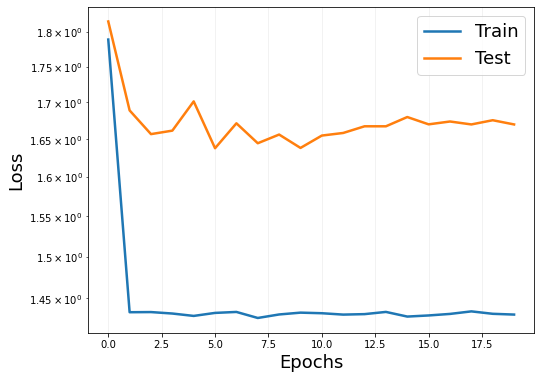

In [20]:
plt.figure(figsize=(8,6))
plt.plot(train_loss, label="Train", linewidth=2.5)
plt.plot(test_loss, label="Test", linewidth=2.5)
plt.grid("on", alpha=0.2)
plt.legend(fontsize=18)
plt.yscale("log")
plt.xlabel("Epochs", fontsize=18)
plt.ylabel("Loss", fontsize=18)
plt.show()

# Evaluating Results

In [21]:
def rmse(true, pred):
    return (((true-pred)**2).mean()**0.5).detach().cpu().numpy()

def l2_error(true, pred):
    return np.linalg.norm(pred.detach().cpu().numpy() - true.detach().cpu().numpy()) / np.linalg.norm(true.detach().cpu().numpy()) 

def compute_metrics(model, loader, mean=0.0, std=1.0):
    model.eval()
    y_ = []
    pred_ = []
    mean = torch.tensor(mean).to(device)
    std = torch.tensor(std).to(device)
    for x, y in iter(loader):
        x, y = x.to(device).float(), y.to(device).float()
        pred = model(x)
        
        temp_input = x[:,13]
        proj = model(x)
        pred = implicit_diffusion(proj, temp_input, input_mean, input_std,
                                 output_mean, output_std)        
        pred = pred.to(dtype=torch.float32)
        
        
        y = y * std + mean
        pred = pred * std + mean
        
        #red = torch.squeeze(pred)
        
        #rint(pred.shape)
        
        y_.append(y)
        pred_.append(pred)
    y_ = torch.cat(y_, dim=0) 
    pred_ = torch.cat(pred_, dim=0)
    
    
    rmse_temp = rmse(y_[:,0], pred_)
    
    l2_error_temp = l2_error(y_[:,0], pred_)
    return rmse_temp, l2_error_temp

In [22]:
rmse_temp, l2_error_temp = compute_metrics(model, test_loader,  mean = output_mean, std = output_std)
print(f"Test Rmse of Temp: {rmse_temp}")
print(f"L2 Error  of Temp: {l2_error_temp}")

Test Rmse of Temp: 4.4851874869722925
L2 Error  of Temp: 0.3088981494221723


In [23]:
rmse_temp, l2_error_temp = compute_metrics(model, train_loader,  mean = output_mean, std = output_std)
print(f"Train Rmse of Temp: {rmse_temp}")
print(f"L2 Error  of Temp: {l2_error_temp}")

Train Rmse of Temp: 4.4224851352218675
L2 Error  of Temp: 0.3454865346515398


# Saving Model

In [24]:
PATH = f"./saved_models/heat_diffusion_model_time.pth"
torch.save(model.state_dict(), PATH)

In [25]:
output_mean

array([11.34604205])